In [4]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import os
from joblib import Parallel, delayed
import warnings

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [5]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [6]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [7]:
def get_orbit(Rs, Vv, ecc):
    output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc+'/output'
    orbit = {}
    orbit['Time'] = []
    orbit['Orbit'] = []
    for idx in tqdm(np.arange(320+1)):
        fname = output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5'
        
        if not os.path.exists(fname):
            print('got to idx='+str(idx-1)+' for Rs,Vv,ecc='+Rs+','+Vv+','+ecc)
            break
        
        t = h5.File(fname, mode='r')
        orbit['Time'].append(t['Header'].attrs['Time'])
        SubhaloPos = t['Subhalo/SubhaloPos'][:]
        if len(SubhaloPos) > 1:
            orbit['Orbit'].append(SubhaloPos[1] - SubhaloPos[0])
        else:
            orbit['Orbit'].append(np.array([0., 0., 0.]))
        t.close()
    
    for k in orbit.keys():
        orbit[k] = np.array(orbit[k])
    
    orbit['Rsep'] = np.linalg.norm(orbit['Orbit'], axis=1)
        
    return orbit

In [8]:
sim0 = ('142', '116', '04')
sim1 = ('129', '116', '04')
sim2 = ('142', '142', '04')

orbit0 = get_orbit(*sim0)
orbit1 = get_orbit(*sim1)

100%|██████████| 321/321 [00:20<00:00, 15.96it/s]


(0.0, 150.0)

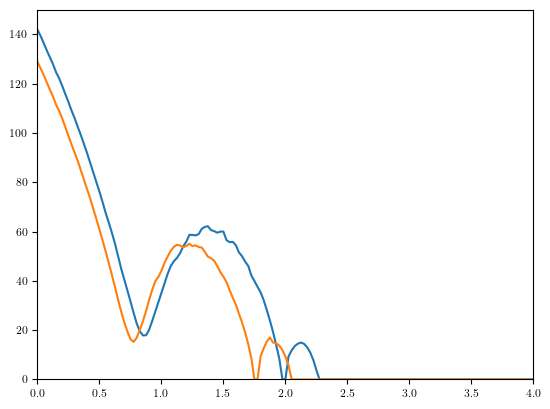

In [9]:
plt.plot(orbit0['Time'], orbit0['Rsep'])
plt.plot(orbit1['Time'], orbit1['Rsep'])
plt.xlim(0, 4)
plt.ylim(0, 150)

In [10]:
print(orbit0['Time'][orbit0['Rsep'] == 0][:10])
print(orbit1['Time'][orbit1['Rsep'] == 0][:10])

[1.9765625  2.         2.27539062 2.30078125 2.32617188 2.3515625
 2.375      2.40039062 2.42578125 2.45117188]
[1.75       1.77539062 2.05078125 2.07617188 2.1015625  2.125
 2.15039062 2.17578125 2.20117188 2.2265625 ]


In [11]:
mergesnap0 = np.where(np.logical_and(orbit0['Time'] > 1.8, orbit0['Rsep'] == 0))[0][0]
mergesnap1 = np.where(np.logical_and(orbit1['Time'] > 1.8, orbit1['Rsep'] == 0))[0][0]

print(mergesnap0)
print(mergesnap1)

79
82


In [22]:
def get_summary(idx, sim, iso=False, rmin=2, rmax=5, dsnap=0.025):
    out = {}
    
    if iso:
        output_dir = basepath + 'runs/MW7iso/lvl4-Ngb64/output'
    else:
        Rs = sim[0]
        Vv = sim[1]
        ecc = sim[2]
    
        key = 'lvl4-Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
        output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output'
    
    sub = h5.File(output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5', mode='r')
    sub0pos = sub['Subhalo/SubhaloPos'][0]
    sub.close()

    snap = h5.File(output_dir + '/snapshot_'+str(idx).zfill(3)+'.hdf5', mode='r')
    NumPart_Total = snap['Header'].attrs['NumPart_Total']
    Time = snap['Header'].attrs['Time']
    out['Time'] = Time
    
    pos0 = snap['PartType0/Coordinates'][:]
    r0 = np.linalg.norm(pos0 - sub0pos, axis=1)
    in_SN = np.logical_and(r0 > rmin, r0 < rmax)
    in_gal = r0 < 15
    
    if NumPart_Total[4] > 0:
        pos4 = snap['PartType4/Coordinates'][:]
        r4 = np.linalg.norm(pos4 - sub0pos, axis=1)
        is_star_in_SN = np.logical_and(r4 > rmin, r4 < rmax)
        age4 = snap['PartType4/GFM_StellarFormationTime'][:]
        is_star_in_SN = np.logical_and(is_star_in_SN, age4 > 0)
        
        mass4 = snap['PartType4/Masses'][:]
        
        metals4 = snap['PartType4/GFM_Metals'][:]
        FeH4 = metals4[:,8] / GFM_SOLAR_ABUNDANCE_IRON
        MgH4 = metals4[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
        
        mass_Mg = np.sum(MgH4 * mass4)
        mass_Fe = np.sum(FeH4 * mass4)
        mass_MgFe = mass_Mg/mass_Fe
        
        out['Mstar'] = np.sum(mass4[is_star_in_SN])
        out['logMgFe'] = np.log10(mass_MgFe)
    else:
        out['Mstar'] = 0.0
        out['logMgFe'] = np.nan
    
    snap.close()
    
    return out

In [23]:
logFeH0_list = np.arange(-1, 0.5+0.1, 0.1)
print(logFeH0_list[9])

-0.1000000000000002


In [28]:
def get_dat_summary(sim, iso=False, rmin=2, rmax=5):

    outs = Parallel(n_jobs=16) (delayed(get_summary)(idx, sim, iso=iso, rmin=rmin, rmax=rmax) 
                                for idx in tqdm(np.arange(320+1), position=0, leave=True))

    dat = {}
    for k in outs[0].keys():
        dat[k] = []

    for out in outs:
        for k in dat.keys():
            dat[k].append(out[k])
    
    for k in dat.keys():
        dat[k] = np.array(dat[k])

    return dat

In [29]:
summary0 = get_dat_summary(sim0, rmin=0, rmax=12)
summary1 = get_dat_summary(sim1, rmin=0, rmax=12)
summaryiso = get_dat_summary(sim2, iso=True, rmin=0, rmax=12)

100%|██████████| 321/321 [00:09<00:00, 34.97it/s]


(-0.05, 0.05)

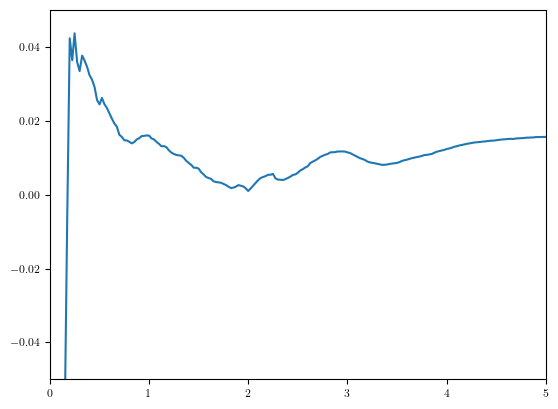

In [35]:
# plt.plot(summary0['Time'], summary0['logMgFe'])
# plt.plot(summary0['Time'], summary0['logMgFe'])
# plt.plot(summaryiso['Time'], summaryiso['logMgFe'])
plt.plot(summary0['Time'], summary0['logMgFe'] - summaryiso['logMgFe'])
plt.xlim(0, 5)
plt.ylim(-0.05, 0.05)